# Long Short Term Memory (LSTM)

In [1]:
import d2l
from mxnet import np, npx
from mxnet.gluon import rnn
npx.set_np()

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

Initializing model parameters.

In [2]:
def get_lstm_params(vocab_size, num_hiddens, ctx):
    num_inputs = num_outputs = vocab_size
    normal = lambda shape : np.random.normal(scale=0.01, size=shape, ctx=ctx)
    three = lambda : (normal((num_inputs, num_hiddens)),
                      normal((num_hiddens, num_hiddens)),
                      np.zeros(num_hiddens, ctx=ctx))
    W_xi, W_hi, b_i = three()  # Input gate parameters
    W_xf, W_hf, b_f = three()  # Forget gate parameters
    W_xo, W_ho, b_o = three()  # Output gate parameters
    W_xc, W_hc, b_c = three()  # Candidate cell parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=ctx)
    # Create gradient
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.attach_grad()
    return params

Initialize the hidden state

In [3]:
def init_lstm_state(batch_size, num_hiddens, ctx):
    return (np.zeros(shape=(batch_size, num_hiddens), ctx=ctx),
            np.zeros(shape=(batch_size, num_hiddens), ctx=ctx))

The model

In [4]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = npx.sigmoid(np.dot(X, W_xi) + np.dot(H, W_hi) + b_i)
        F = npx.sigmoid(np.dot(X, W_xf) + np.dot(H, W_hf) + b_f)
        O = npx.sigmoid(np.dot(X, W_xo) + np.dot(H, W_ho) + b_o)
        C_tilda = np.tanh(np.dot(X, W_xc) + np.dot(H, W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * np.tanh(C)
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H, C)

Training

Perplexity 14.4, 10748 tokens/sec on gpu(0)
time traveller te at at at at at at at at at at at at at at at a
traveller te at at at at at at at at at at at at at at at a


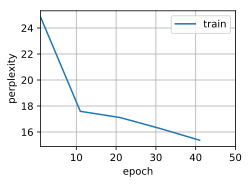

In [5]:
vocab_size, num_hiddens, ctx = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 50, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, ctx, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

Concise implementation

Perplexity 1.1, 217383 tokens/sec on gpu(0)
time traveller  it s against reason said filby  what reason said
traveller  st sacexting to reck ot moving as onewho repeats


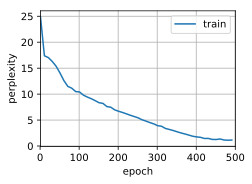

In [6]:
lstm_layer = rnn.LSTM(num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs*10, ctx)